## Create Initial states

In [15]:
import numpy as np
from pathlib import Path
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt

from src.models.mixture import MixtureDegModel
from src.models.normal import NormalDegradationModel as NModel

In [16]:
data_name = "DS01"

device = "cpu"
experiment_dir = Path('experiments')/data_name
states_dir = experiment_dir/'states'
os.makedirs(states_dir, exist_ok=True)

## Import training data


In [17]:
hi_df = pd.read_csv(experiment_dir/'hidata_dev.csv')
units = hi_df['unit'].astype(int).unique().tolist()
units 

[1, 2, 3, 4, 5, 6]

### Extract degradation onset

In [18]:
onsets = {unit: hi_df[(hi_df['unit']==unit) & (hi_df['hs']==0)]['cycle'].values[0] for unit in units}
del hi_df['hs']

In [19]:
perform_names = [col for col in hi_df.columns if col not in ['unit','cycle']]

performs = {name: 
    {unit: hi_df[hi_df['unit']==unit][name].values for unit in units} 
    for name in perform_names
}
time = {unit: hi_df[hi_df['unit']==unit]['cycle'].values for unit in units}

## Load best model

In [20]:
t = np.linspace(0.1, 100, 400)  # Start from 0.1 instead of 0.0 (LogNormal support is t > 0)
s = np.linspace(0.0, 1.0, 300)

mix_models: dict[str,MixtureDegModel]= {}
for name, units_perform in performs.items():
    models = []
    for unit, perform in units_perform.items():
        best_model = NModel(onset=onsets[unit])
        best_model.load_state_dict(
			torch.load(states_dir /name/f'unit_{unit}'/ "best_model.pt", map_location=device)
		)
        best_model.to(device)
        best_model.eval()
        models.append(best_model)
    
    # build mix model
    K = len(models)
    mix_models[name] = MixtureDegModel(models, weights=torch.ones(K)/K)

## Mixture pdf 

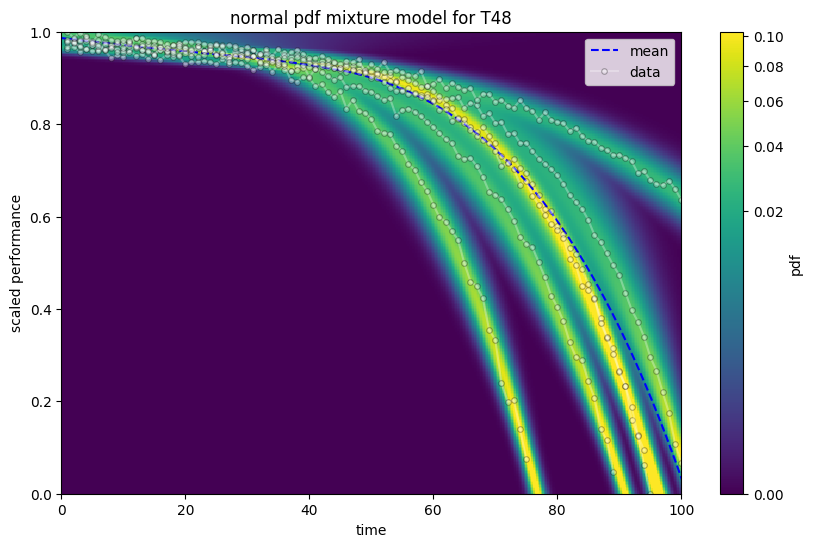

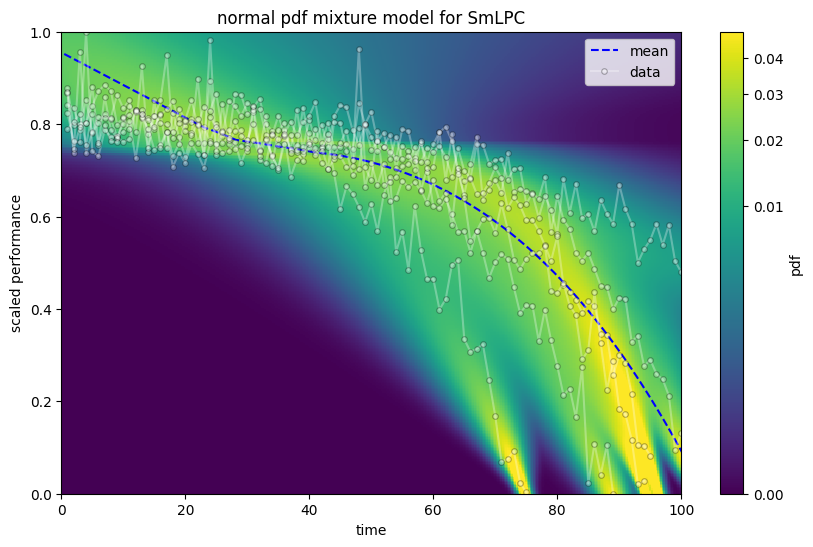

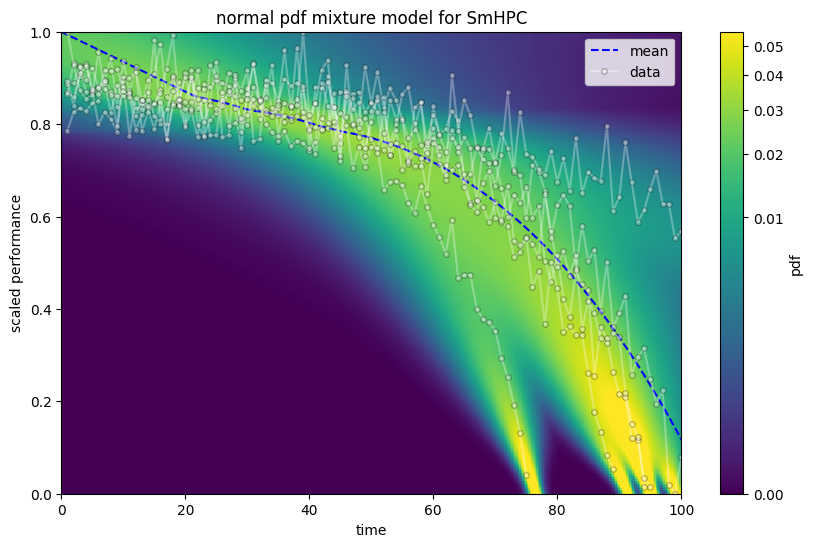

In [21]:
mixes: dict[str,MixtureDegModel]= {}
for name, mix_model in mix_models.items():
    ## Plot mix model
    ax=mix_model.plot_distribution(t, s, 
                    func="pdf",
					title=f"normal pdf mixture model for {name}",
					plot_mean=True,
		)
    
    # Plot data
    first = True
    for unit,s_data in performs[name].items():
        t_data = time[unit]
        ax.plot(t_data,s_data,'o-',
				color='white',alpha=0.3,markersize=4,markeredgecolor='black',markeredgewidth=0.8,
				label='data' if first else None)
        first = False
    
    # adjust and plot
    ax.set_xlim([0, t.max()])
    ax.legend()
    plt.show()

## Mixture cdf 

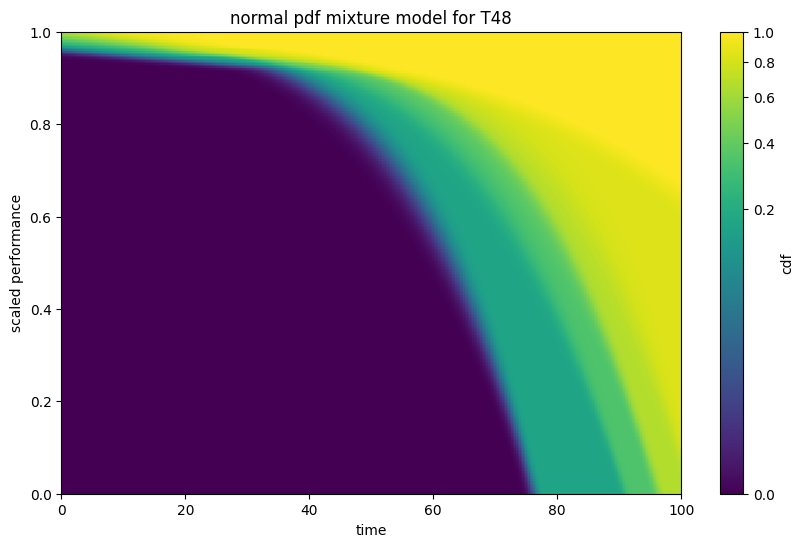

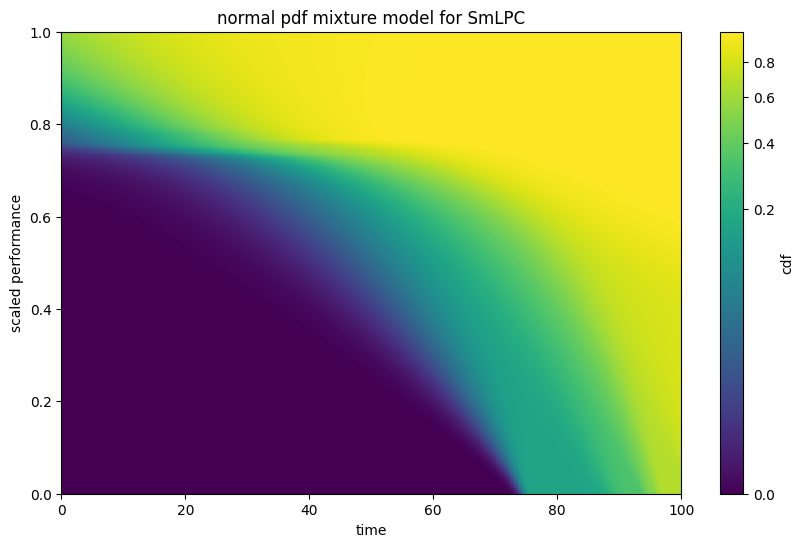

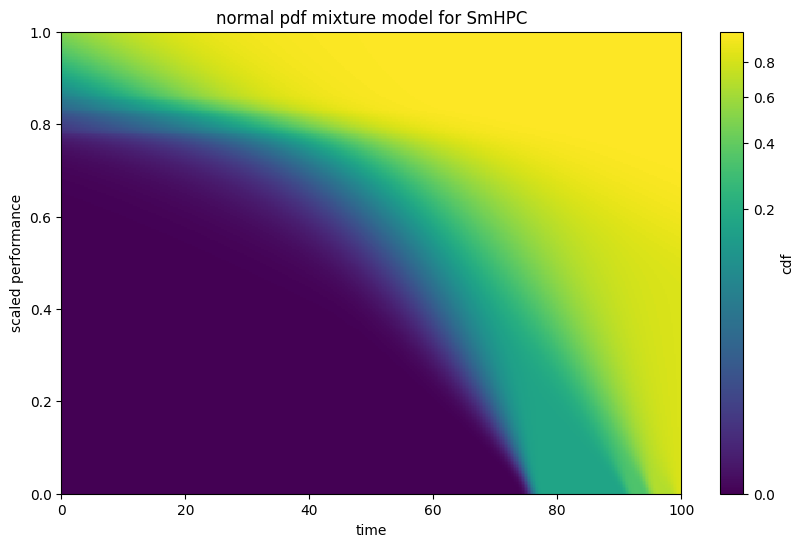

In [22]:
mixes: dict[str,MixtureDegModel]= {}
for name, mix_model in mix_models.items():
    ## Plot mix model cdf
    ax=mix_model.plot_distribution(t, s, 
                    func="cdf",
					title=f"normal pdf mixture model for {name}",
					plot_mean=False,
     				legend_loc=None,
		)
    # adjust and plot
    ax.set_xlim([0, t.max()])
    plt.show()

## Mixture EOL pdf distribution

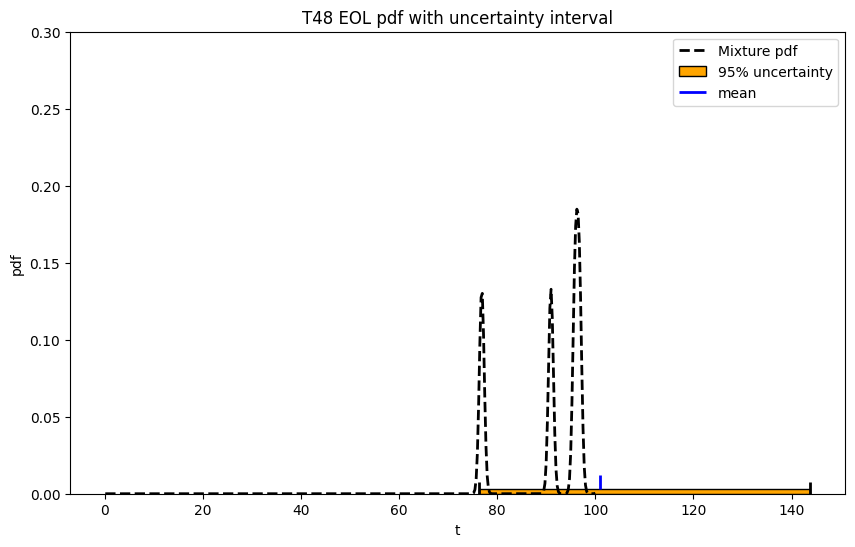

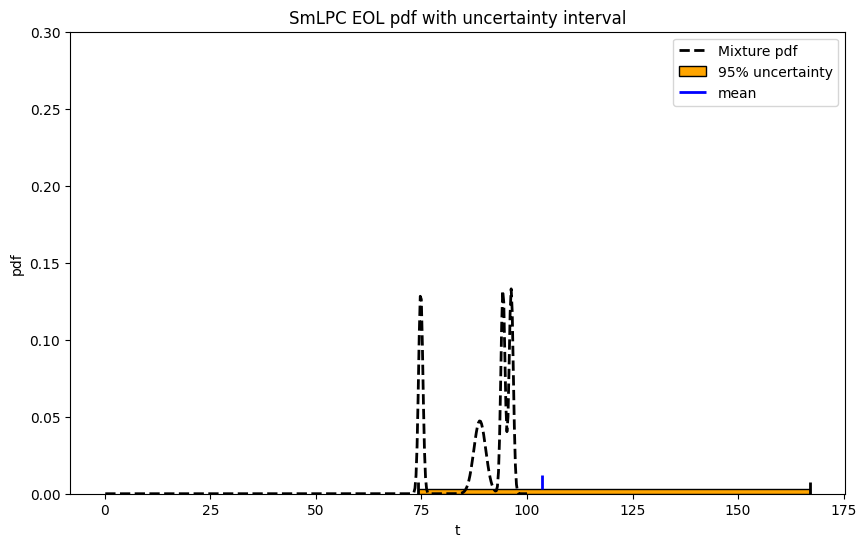

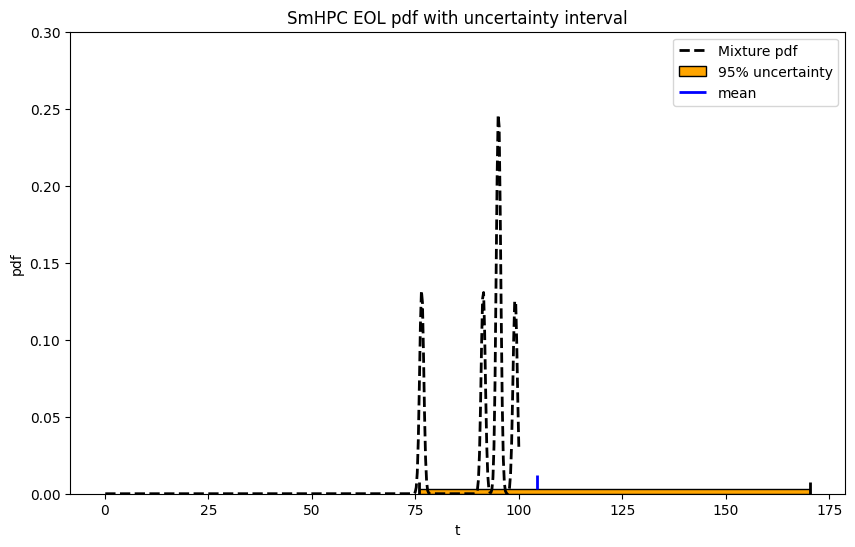

In [23]:
for name,model in mix_models.items():
    ax=model.plot_random_variable(t,s=0,func='pdf',max_prob=0.3,title=f"{name} EOL pdf with uncertainty interval") 
    s_torch = torch.tensor([0], dtype=torch.float32).to(device)
    level =0.95
    lower, mean, upper = model.uncertainty_interval(s_torch, level=0.95)
    model.plot_uncertainty_interval(
                ax=ax,
                lower=lower.item(),
                mean=mean.item(),
                upper=upper.item(),
                ymax=0.3,
                unc_label=f"{int(level * 100)}% uncertainty",
                mean_label="mean",
            )
    plt.show()

## Mixture EOL cdf distribution

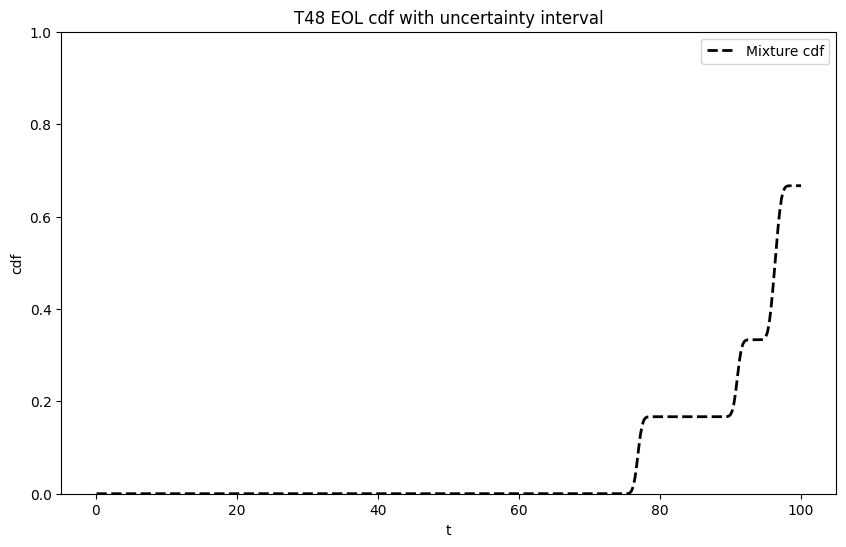

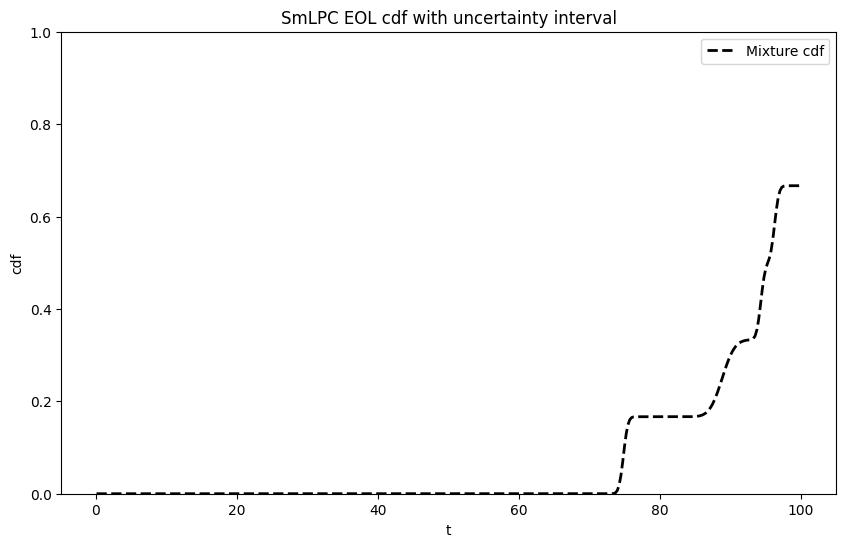

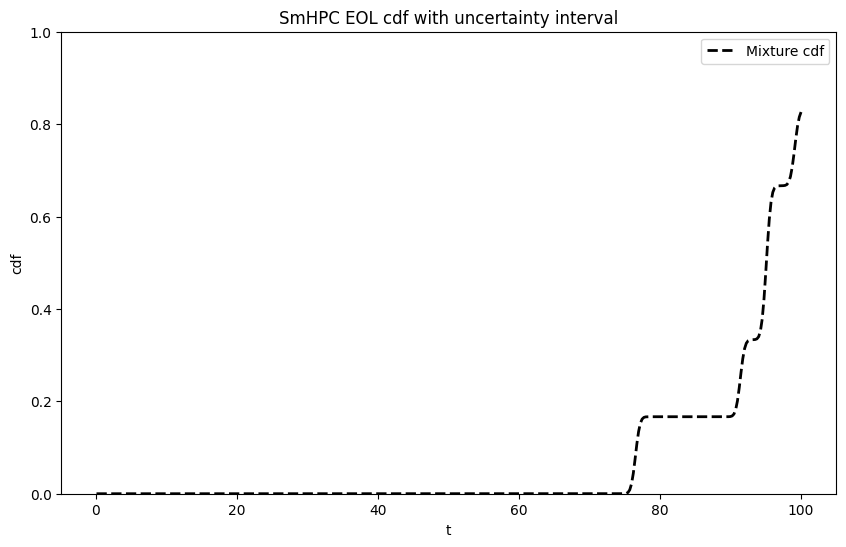

In [24]:
for name,model in mix_models.items():
    ax=model.plot_random_variable(t,s=0,func='cdf',title=f"{name} EOL cdf with uncertainty interval") 
    plt.show()

## Mixture uncertainty interval

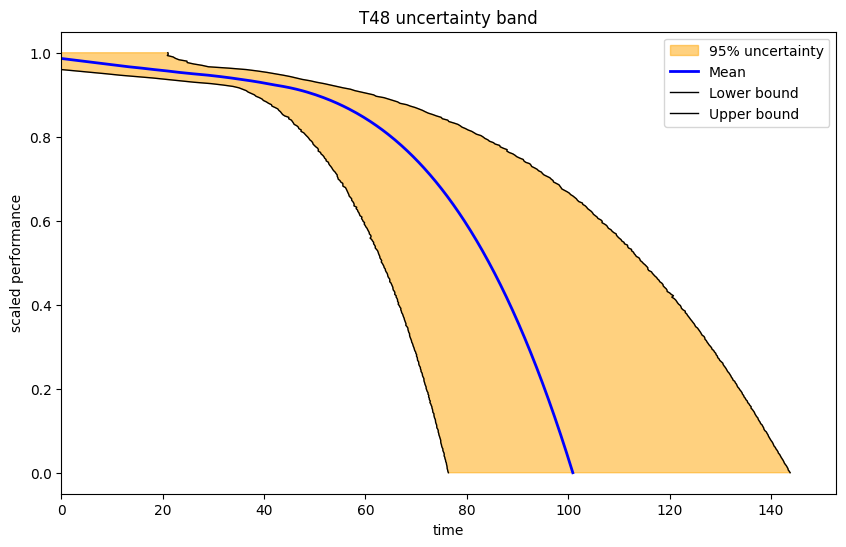

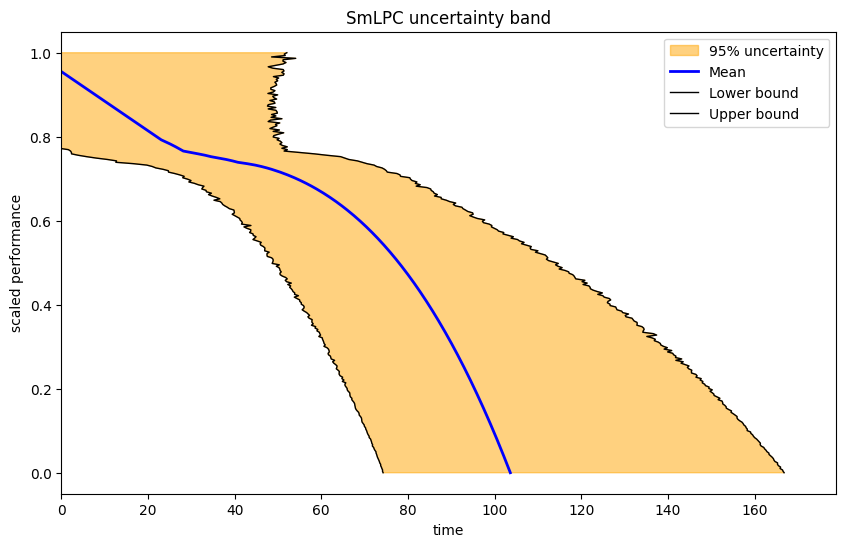

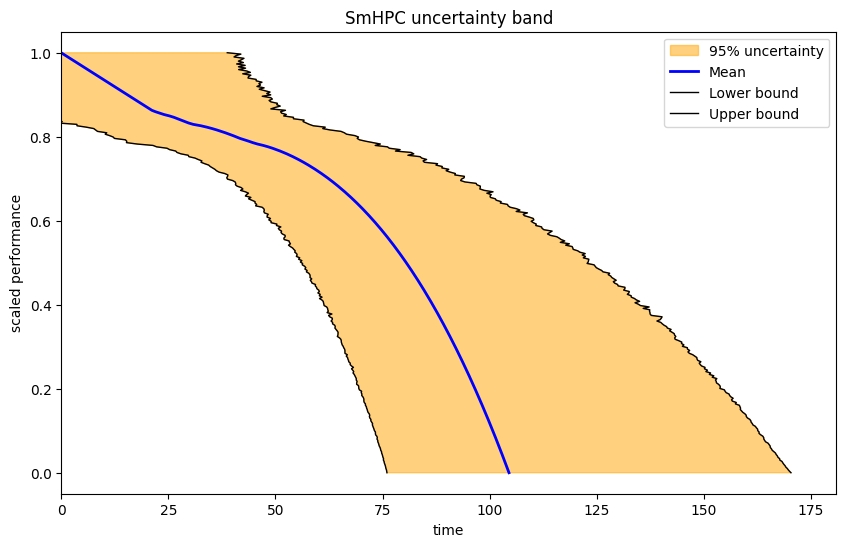

In [25]:
for name,model in mix_models.items():
    level = 0.95
    s_torch = torch.tensor(s, dtype=torch.float32)
    lower, mean, upper = model.uncertainty_interval(s_torch, level=level)
    ax=model.plot_uncertainty_band(s,lower, mean, upper,level=level, title=f"{name} uncertainty band") 
    plt.show()
